#Authors
**Author 1 (name and surname):** Alan Garcia Justel

**Author 2 (name and surname):** Julen Rodríguez Meneses

#Implementing Image Rotation Pretext Training for Self Supervised Learning
In this assignment, you will implement a SSL system based on the pre-text task of **rotation prediction**. Have a look at the slides to properly understand the pre-text task and the SSL system.

##Preamble
Import the needed libraries and download the fashion MNIST dataset.

In [ ]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from keras import datasets, layers, models, callbacks
from keras.models import load_model

import cv2

from tabulate import tabulate
import pickle
import os

In [ ]:
data=keras.datasets.fashion_mnist

# Getting the data
(X_train, y_train), (X_test, y_test) = data.load_data()


In the next cells, we normalize the images and we build our train, validation and test sets from the oficial sets. Notice how we generate an unlabeled and a labelled split from the original training split.

In [ ]:
# Normalizing the dataset

X_train = X_train/255
X_test = X_test/255


# Splitting the test dataset into validation and test dataset
X_val = X_test[:5000]
y_val = y_test[:5000]

X_test = X_test[5000:]
y_test = y_test[5000:]

In [ ]:
# Creating an unlabeled dataset from training dataset
X_unlabeled = X_train[10000:]

# Creating a labeled dataset from training dataset
X_labeled = X_train[:10000]
y_labeled = y_train[:10000]

##Exercise 1
Generate the artificial labels for the pre-text task. Use rotations of 0, 90, 180 and 270 over `X_unlabeled`. We expect the following outputs from this exercise:

*   `X_train_0` -> all the images from `X_unlabeled` without any rotation (0 degrees)
*   `X_train_90` -> all the images from `X_unlabeled` with 90 degrees of rotation.
*   `X_train_180` -> all the images from `X_unlabeled` with 180 degrees of rotation.
*   `X_train_270` -> all the images from `X_unlabeled` with 270 degrees of rotation.

You also have to generate the artificial labels:

*   `y_train_0`: vector of size 50000 and 0 values.
*   `y_train_90`: vector of size 50000 and 90 values.
*   `y_train_180`: vector of size 50000 and 180 values.
*   `y_train_270`: vector of size 50000 and 270 values.

**NOTE:** Use the provided varaible names, to make the notebook work without any problems. The next cells assume those variable names.


In [ ]:
X_train_0 = np.zeros_like(X_unlabeled)
X_train_90 = np.zeros_like(X_unlabeled)
X_train_180 = np.zeros_like(X_unlabeled)
X_train_270 = np.zeros_like(X_unlabeled)

# Create rotated dataset
for i in range(len(X_unlabeled)):
    image = X_unlabeled[i]
    X_train_0[i] = image  # No rotation
    X_train_90[i] = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)          # 90deg   rotation
    X_train_180[i] = cv2.rotate(image, cv2.ROTATE_180)                  # 180deg  rotation
    X_train_270[i] = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)  # 270deg  rotation

# Create Labels
y_train_0 = np.zeros(50000, dtype=int)      # 0deg    rotation  -> label: 0
y_train_90 = np.full(50000, 1, dtype=int)   # 90deg   rotation  -> label: 1
y_train_180 = np.full(50000, 2, dtype=int)  # 180deg  rotation  -> label: 2
y_train_270 = np.full(50000, 3, dtype=int)  # 270deg  rotation  -> label: 3


# X_train_0, X_train_90, X_train_180, X_train_270: Rotated images
# y_train_0, y_train_90, y_train_180, y_train_270: Labels

Now we will create our pre-text dataset concatenating previous sets. We will also shuffle the data and generate validation and test split for the pre-text task itself:

In [ ]:
# Concatenating Datasets
X_train_unlabeled_full=np.concatenate((X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
y_train_unlabeled_full=np.concatenate((y_train_0, y_train_90, y_train_180, y_train_270), axis=0)

In [ ]:
# The function will distribute the samples uniformly over dataset
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
# Randomly shuffling the concatenated dataset
X_train_unlabeled_full_shuffled, y_train_unlabeled_full_shuffled = unison_shuffled_copies(X_train_unlabeled_full, y_train_unlabeled_full)

In [ ]:
# Creating Validation and Test Dataset for Pretext Task
X_rot_val, X_rot_train = X_train_unlabeled_full_shuffled[:10000], X_train_unlabeled_full_shuffled[10000:]
y_rot_val, y_rot_train = y_train_unlabeled_full_shuffled[:10000], y_train_unlabeled_full_shuffled[10000:]

##Exercise 2
Build a CNN with the following architecture:



*   Conv layer of 64 filters, $7 \times 7$ filter size and *same* padding.
*   Max pooling ($2 \times 2$, stride of 2).
*   Conv layer of 128 filters, $3 \times 3$ filter size and *same* padding.
*   Conv layer of 128 filters, $3 \times 3$ filter size and *same* padding.
*   Max pooling ($2 \times 2$, stride of 2).
*   Conv layer of 256 filters, $3 \times 3$ filter size and *same* padding.
*   Conv layer of 256 filters, $3 \times 3$ filter size and *same* padding.
*   Max pooling ($2 \times 2$, stride of 2).
*   Dense layer of 128 neurons.
*   Dense layer of 64 neurons.
*   Final classifier layer with 4 neurons (the possible rotations).

Use ReLU activations on all intermediate layers and dropout layers with 0.5 rate after each dense layer.

Train this CNN for 5 epochs and use the validation data to monitor its performance.



In [ ]:
def show_model_hist(model_hist:dict, model_name:str="", title:str="", color:str='#87CEEB', axes=None):
    """Show all the trained model hist.
    INPUT: model_hist
    """

    loss      = model_hist.history['loss']
    val_loss  = model_hist.history['val_loss']
    acc       = model_hist.history['accuracy']
    val_acc   = model_hist.history['val_accuracy']

    if axes is None:
      fig, axes = plt.subplots(2,2, figsize=(24, 10))
      fig.suptitle(title)

    axes[0, 0].set_title('Training Loss')
    axes[0, 0].plot(loss, color=color, label=model_name)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss Value')

    axes[1, 0].set_title('Validation Loss')
    axes[1, 0].plot(val_loss, color=color, label=model_name)
    axes[1, 0].set_xlabel('Validation Step')
    axes[1, 0].set_ylabel('Loss Value')

    axes[0, 1].set_title('Training Acc')
    axes[0, 1].plot(acc, color=color, label=model_name)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Acc Value')

    axes[1, 1].set_title('Validation Acc')
    axes[1, 1].plot(val_acc, color=color, label=model_name)
    axes[1, 1].set_xlabel('Validation Step')
    axes[1, 1].set_ylabel('Acc Value')


def show_model_inference(model, X_val, y_val, num_samples:int=8):
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    X_sample = X_val[indices]
    y_sample = y_val[indices]
    y_pred = model.predict(X_sample)
    y_pred_labels = np.argmax(y_pred, axis=1)

    fig, axes = plt.subplots(1, num_samples, figsize=(2 * num_samples, 2))
    for i in range(num_samples):
      axes[i].set_title(f"Real: {y_sample[i]}\nPred: {y_pred_labels[i]}", fontsize=10)
      axes[i].imshow(X_sample[i], cmap='gray')
      axes[i].axis('off')
    plt.show()

In [ ]:
def cnn_model(output_neurons:int=4):
    af  = "relu"  # Activation Function
    dpb = 0.5     # DropOut prob
    conv_padding = "same"

    # Define input
    inputs = keras.Input((28, 28, 1))

    # Conv Block 1
    c1 = layers.Conv2D(64, (7, 7), padding=conv_padding)(inputs)
    p1 = layers.MaxPooling2D((2, 2), strides=2)(c1)

    # Conv Block 2
    c2 = layers.Conv2D(128, (3, 3), padding=conv_padding)(p1)
    c2 = layers.Conv2D(128, (3, 3), padding=conv_padding)(c2)
    p2 = layers.MaxPooling2D((2, 2), strides=2)(c2)

    # Conv Block 3
    c3 = layers.Conv2D(256, (3, 3), padding=conv_padding)(p2)
    c3 = layers.Conv2D(256, (3, 3), padding=conv_padding)(c3)
    p3 = layers.MaxPooling2D((2, 2), strides=2)(c3)

    # Flatten
    flatten = layers.Flatten()(p3)

    # Fully Connected Head for multi-class classification
    d1 = layers.Dense(128, activation=af)(flatten)
    d1 = layers.Dropout(dpb)(d1)

    d2 = layers.Dense(64, activation=af)(d1)
    d2 = layers.Dropout(dpb)(d2)

    outputs = layers.Dense(output_neurons, activation="softmax")(d2)
    return keras.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
def train_model(model, model_path, model_hist_path, X_train, X_val, y_train, y_val, epochs=5, batch_size=32, callbacks_list=[], retrain_model=False):
    model_hist = None
    if retrain_model or not os.path.exists(model_path):
        model_hist = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list
        )
        model.save(model_path)
        with open(model_hist_path, "wb") as f:
            pickle.dump(model_hist, f)
    else:
        model = load_model(model_path)
        with open(model_hist_path, "rb") as f:
          model_hist = pickle.load(f)
    return model, model_hist

In [ ]:
base_model = cnn_model()
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,413,444 (5.39 MB)

 Trainable params: 1,413,444 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Hyperparams
epochs = 5
initial_lr = 1e-4
batch_size = 32
model_name = "cnn_rot_model"
model_dir_path = "."
retrain_model = False

# Define model paths
rot_model_path      = os.path.join(model_dir_path, f"{model_name}.keras")
rot_model_hist_path = os.path.join(model_dir_path, f"{model_name}_hist.pkl")

# Callbacks for training
callbacks_list = [
    callbacks.ModelCheckpoint(rot_model_path, save_best_only=True, monitor="val_accuracy", mode="max"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# Compile model with AdamW optimizer
base_model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=initial_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train or load model
rot_model, rot_model_hist = train_model(base_model, rot_model_path, rot_model_hist_path, X_rot_train, X_rot_val, y_rot_train, y_rot_val, epochs=epochs, batch_size=batch_size, callbacks_list=callbacks_list, retrain_model=retrain_model)

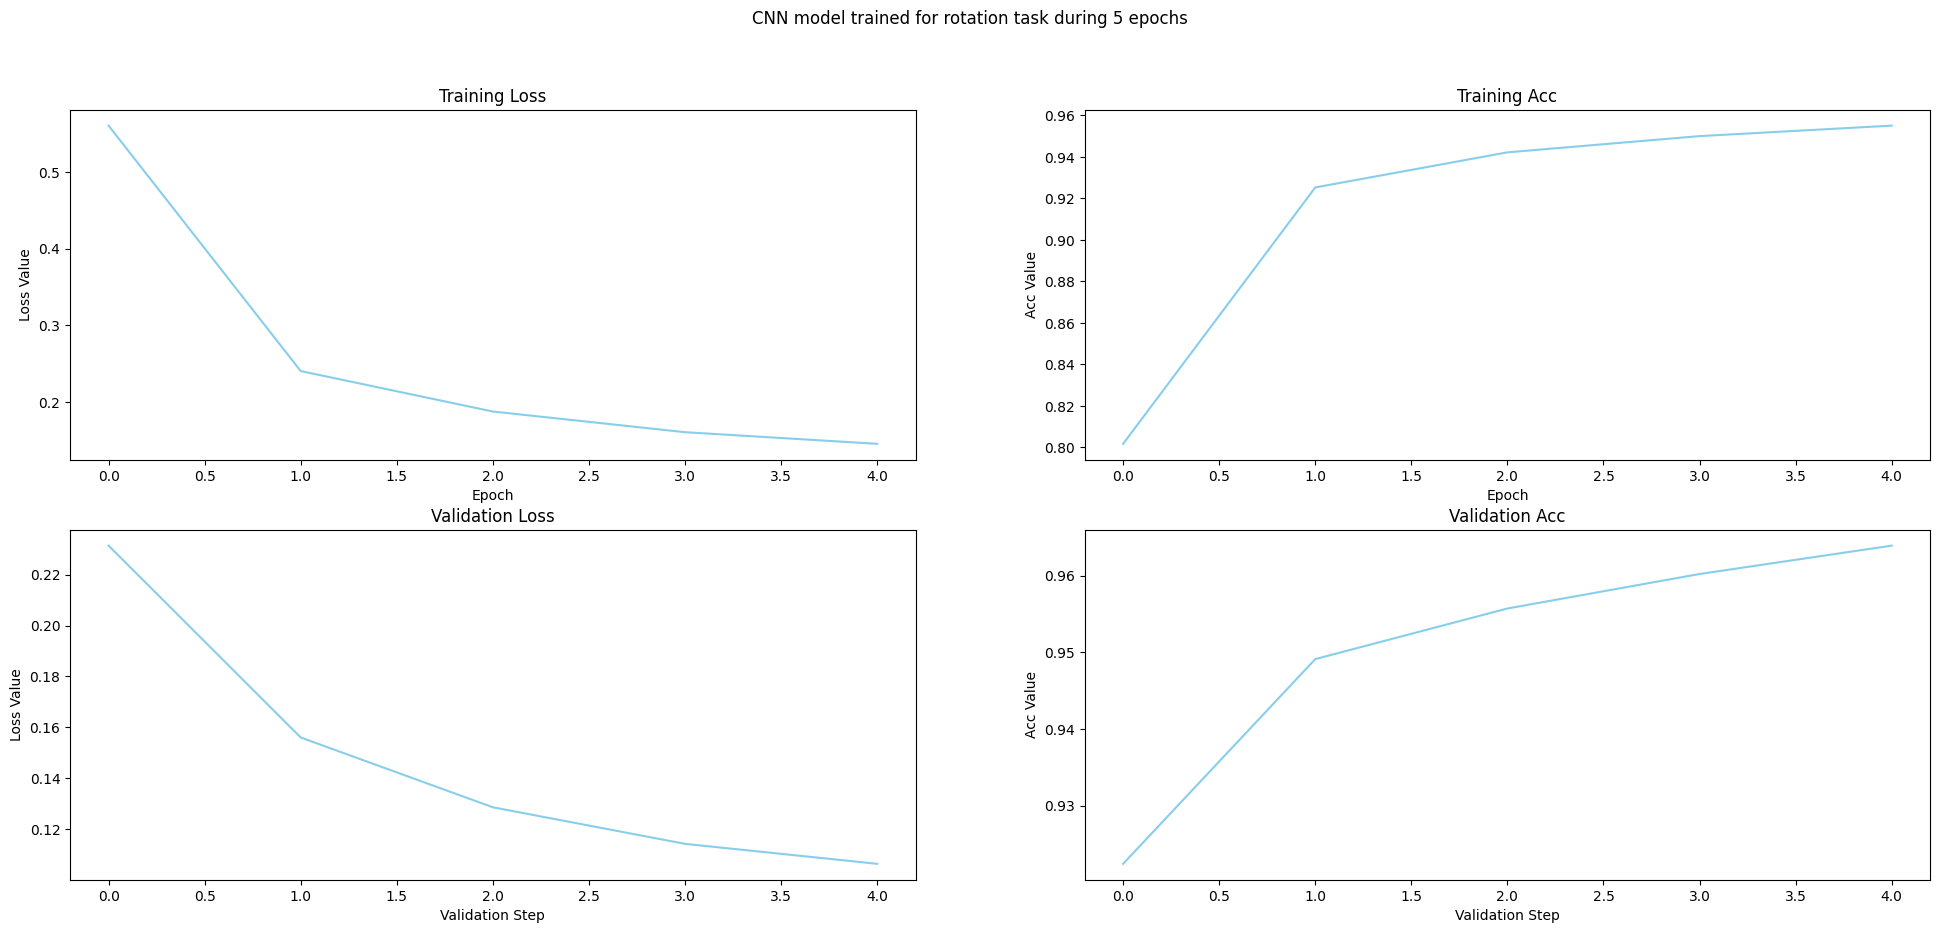

In [ ]:
show_model_hist(rot_model_hist, model_name="rot_model", title="CNN model trained for rotation task during 5 epochs")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


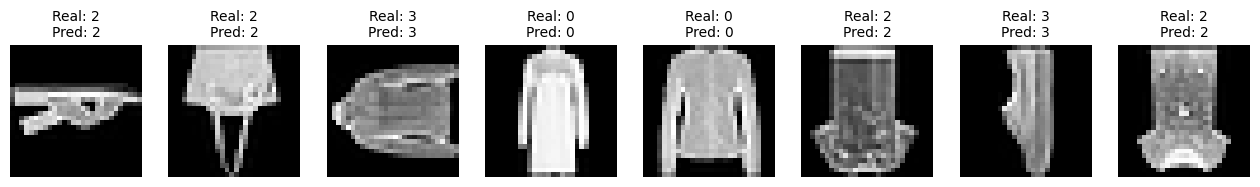

In [ ]:
show_model_inference(rot_model, X_rot_val, y_rot_val, 8)

##Exercise 3
Now you have a CNN pretrained on a pre-text task. Let's see how well it performs for the target task: classifying images from Fashion MNIST using the original 10 labels. For that purpose follow these steps:


1.   Remove the last dense layer from the CNN.
2.   Add a new dense layer with 10 neurons.
3.   Freeze all the layers except the dense layers of the CNN.
4.   Train the model for 10 epochs using `X_labeled`. Use also `X_val` as your validation data.
5.   Evaluate the performance of your model on the test set (`X_test`).

If you do everything correctly, you should have a validation and test accuracy of around 83%.



In [ ]:
# Keep everything except the last dense layers and freeze conv layers
ssl_model = keras.Model(inputs=rot_model.input, outputs=rot_model.layers[-2].output)
x = layers.Dense(10, activation="softmax")(ssl_model.output)
ssl_model = keras.Model(inputs=ssl_model.input, outputs=x)
ssl_model.summary()
print()
# Freeze only conv layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Check trainable layers
info = []
for layer in ssl_model.layers:
    info.append((layer.name, layer.trainable))
print(tabulate(info, headers=["Layer", "Trainable"]))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 28, 28, 64)          │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 303,946 (1.16 MB)

 Non-trainable params: 1,109,888 (4.23 MB)


Layer             Trainable
----------------  -----------
input_layer_5     True
conv2d_25         False
max_pooling2d_15  False
conv2d_26         False
conv2d_27         False
max_pooling2d_16  False
conv2d_28         False
conv2d_29         False
max_pooling2d_17  False
flatten_5         False
dense_51          True
dropout_10        True
dense_52          True
dropout_11        True
dense_3           True


In [ ]:
np.unique(y_labeled)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# Hyperparams
epochs = 10
initial_lr = 1e-4
batch_size = 32
model_name = "cnn_ssl_model"
model_dir_path = "."
retrain_model = False

# Define model paths
ssl_model_path      = os.path.join(model_dir_path, f"{model_name}.keras")
ssl_model_hist_path = os.path.join(model_dir_path, f"{model_name}_hist.pkl")

# Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(ssl_model_path, save_best_only=True, monitor="val_accuracy", mode="max"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# Compile with AdamW
ssl_model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=initial_lr, clipvalue=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

ssl_model, ssl_model_hist = train_model(ssl_model, ssl_model_path, ssl_model_hist_path, X_labeled, X_val, y_labeled, y_val, epochs=epochs, batch_size=batch_size, callbacks_list=callbacks_list, retrain_model=retrain_model)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1545 - loss: 2.2934 - val_accuracy: 0.4164 - val_loss: 1.8909
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3121 - loss: 1.9180 - val_accuracy: 0.5890 - val_loss: 1.4986
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3899 - loss: 1.6529 - val_accuracy: 0.6612 - val_loss: 1.2500
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4556 - loss: 1.4888 - val_accuracy: 0.7094 - val_loss: 1.0930
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5101 - loss: 1.3450 - val_accuracy: 0.7278 - val_loss: 0.9584
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5407 - loss: 1.2493 - val_accuracy: 0.7298 - val_loss: 0.9012
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5891 - loss: 1.1345 - val_accuracy: 0.7420 - val_loss: 0.8323
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6033 - loss: 1.0980 - val_accuracy: 

In [ ]:
# Evaluate the model on test data
ssl_test_loss, ssl_test_acc = ssl_model.evaluate(X_test, y_test)
print(f"Test Loss: {ssl_test_loss}")
print(f"Test Accuracy: {ssl_test_acc}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7448 - loss: 0.7386
Test Loss: 0.7220045328140259
Test Accuracy: 0.7519999742507935


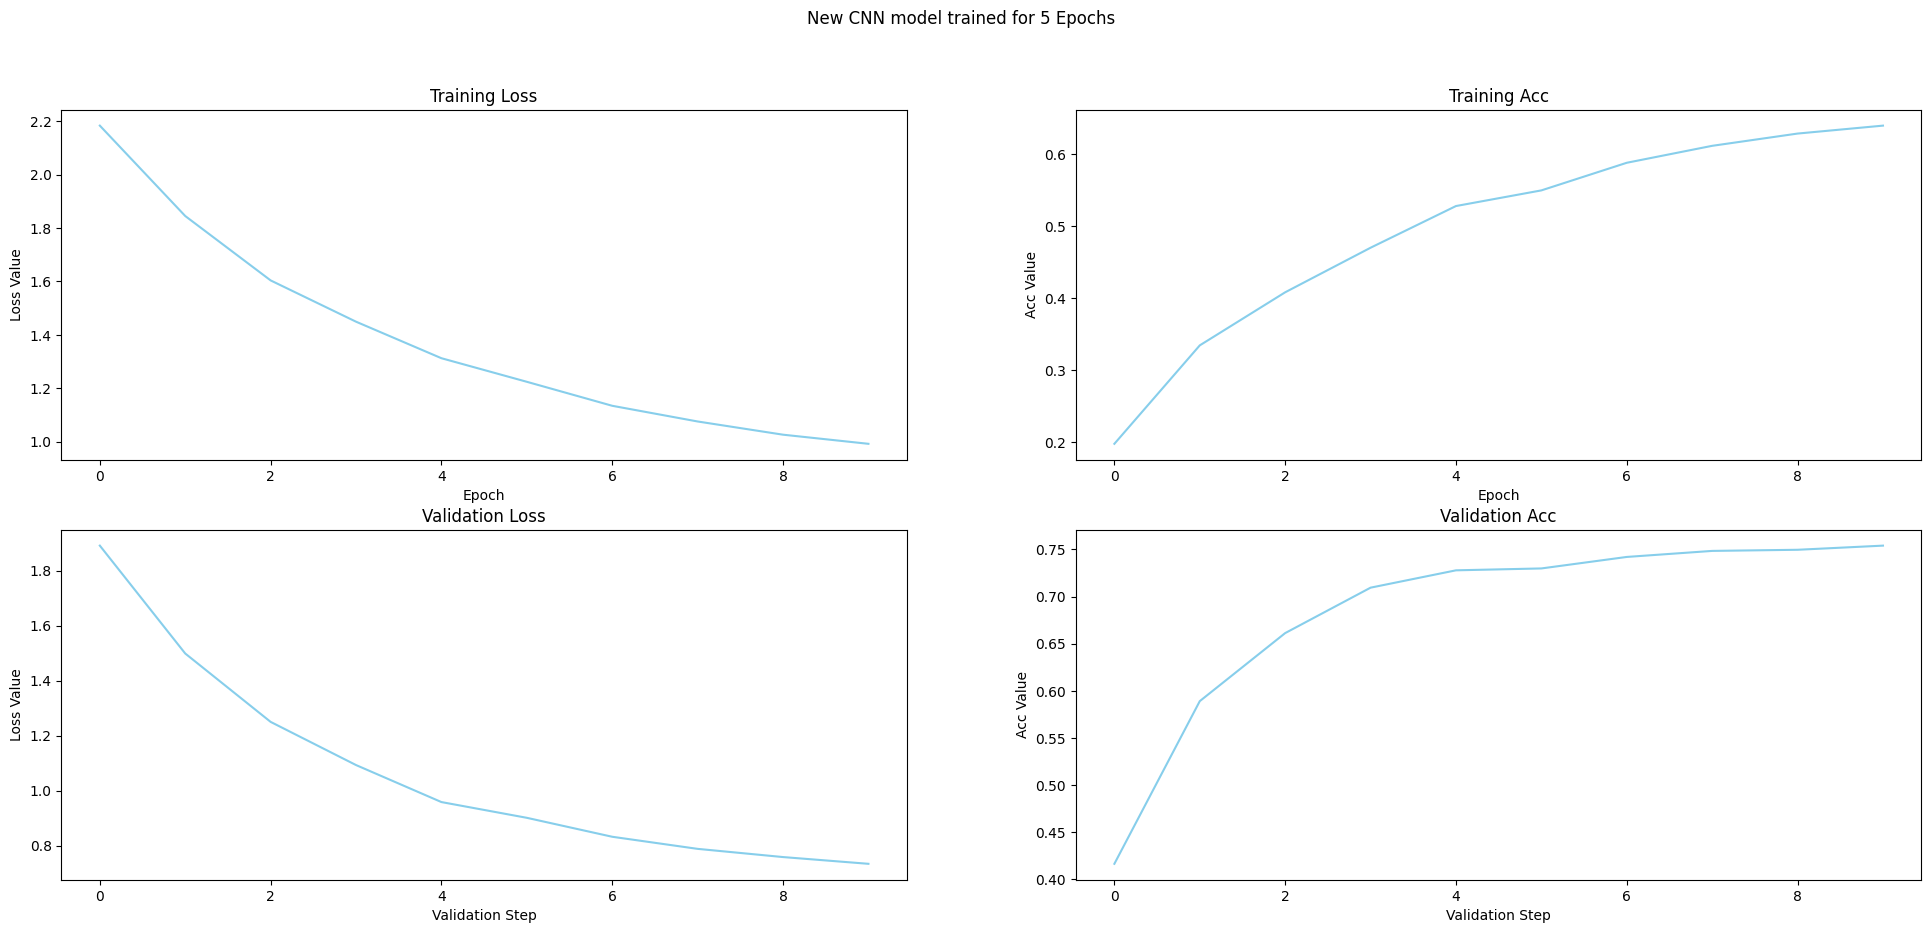

In [ ]:
show_model_hist(ssl_model_hist, model_name="new_model", title="New CNN model trained for 5 Epochs")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


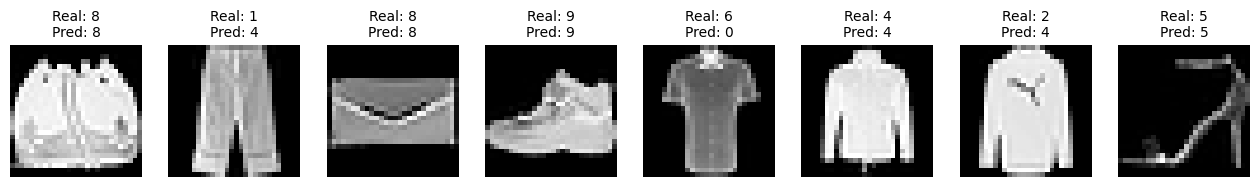

In [ ]:
show_model_inference(ssl_model, X_test, y_test, 8)

##Exercise 4
To compare the two-stage training model (SSL + supervised fine-tuning), let's train and evaluate the same CNN architecture in a supervised manner on `X_labeled`. Remember to use the suitable validation data and evaluate the final model on the test data. Looking at the results, what are your conclusions?

In [ ]:
baseline_model = cnn_model(output_neurons=10)
baseline_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 64)          │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Hyperparams
epochs = 10
initial_lr = 1e-4
batch_size = 32
model_name = "cnn_baseline_model"
model_dir_path = "."
retrain_model = False

# Define model paths
baseline_model_path      = os.path.join(model_dir_path, f"{model_name}.keras")
baseline_model_hist_path = os.path.join(model_dir_path, f"{model_name}_hist.pkl")

# Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(baseline_model_path, save_best_only=True, monitor="val_accuracy", mode="max"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# Compile with AdamW
baseline_model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=initial_lr, clipvalue=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

baseline_model, baseline_model_hist = train_model(baseline_model, baseline_model_path, baseline_model_hist_path, X_labeled, X_val, y_labeled, y_val, epochs=epochs, batch_size=batch_size, callbacks_list=callbacks_list, retrain_model=retrain_model)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_72']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.3400 - loss: 1.8205 - val_accuracy: 0.7416 - val_loss: 0.8919
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6001 - loss: 1.1408 - val_accuracy: 0.7694 - val_loss: 0.6707
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6795 - loss: 0.9202 - val_accuracy: 0.7952 - val_loss: 0.5937
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7194 - loss: 0.8101 - val_accuracy: 0.8008 - val_loss: 0.5571
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7479 - loss: 0.7195 - val_accuracy: 0.8304 - val_loss: 0.4956
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7499 - loss: 0.6847 - val_accuracy: 0.8324 - val_loss: 0.4826
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7830 - loss: 0.6102 - val_accuracy: 0.8430 - val_loss: 0.4599
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7999 - loss: 0.5796 - val_accuracy: 0.8428 -

In [ ]:
# Evaluate the model on test data
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test, y_test)
print(f"Test Loss: {baseline_test_loss}")
print(f"Test Accuracy: {baseline_test_acc}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8398 - loss: 0.4459
Test Loss: 0.4192976653575897
Test Accuracy: 0.84579998254776


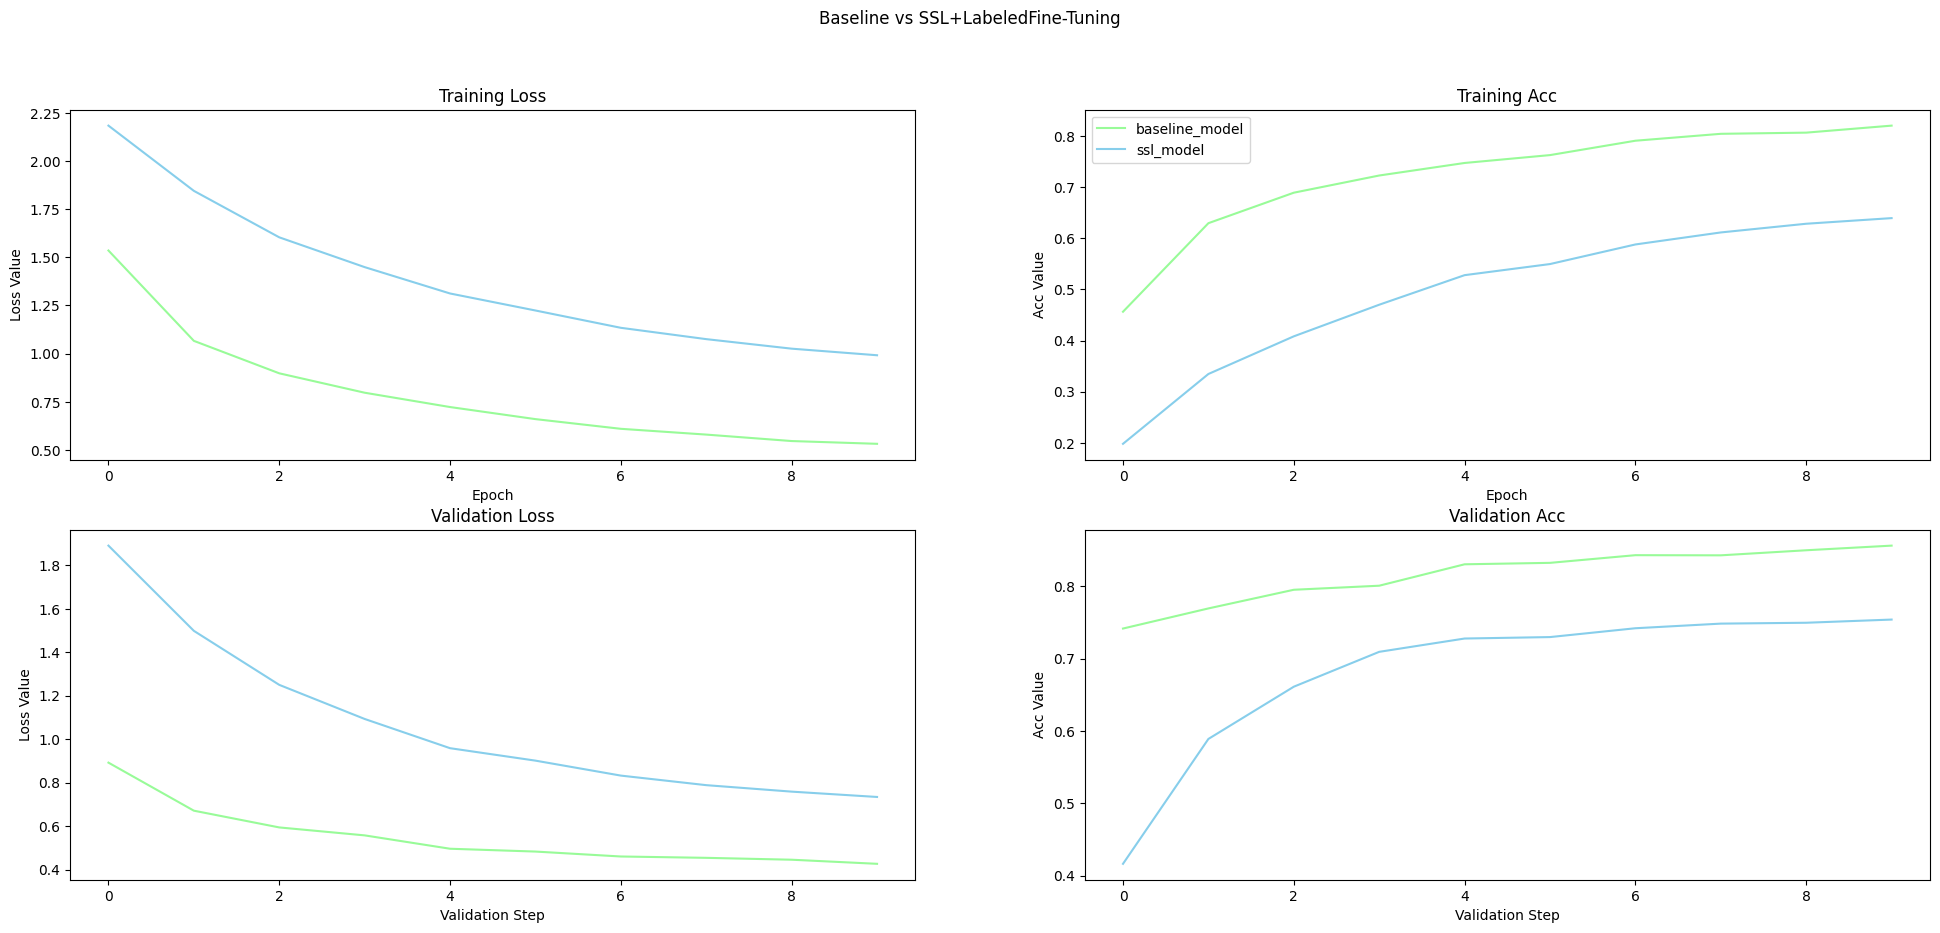

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(24, 10))
fig.suptitle("Baseline vs SSL+LabeledFine-Tuning")
show_model_hist(baseline_model_hist, model_name="baseline_model", color='#98FB98', axes=axes)
show_model_hist(ssl_model_hist, model_name="ssl_model", color='#87CEEB', axes=axes)
axes[0, 1].legend()
plt.show()

It seems that the baseline model (full trained on the labeled dataset) has a better performance on the test split than the model which was trained on a prediction of rotation of the images task and the was fine-tuned with the labeled dataset. The baseline model has a accuracy of $0.846$ while the other model has an accuracy of $0.752$ both on the test split.

This may indicate that, in this case, directly training on the labeled data yields better results.


# Egela submission
Copy this notebook to your Drive and solve the proposed exercises there.

Rename the notebook as `assignment-9-name1-surname1-name2-surname2.ipynb` (replace *name1-surname1* and *name2-surname2* with team member names and surnames).

Use the "share" button and make sure you configure such that "Anyone on the Internet with this link can view".

Copy the link provided by the "share" menu and paste it here. Only one member of the team should submit the notebook

<font color=red>**Important**</font>: Make sure the notebook is <u>fully run</u> when and the "traces" (run times) are visible when you submit.

**Submission deadline:** Sunday, March 9 2025, 23:59h.